# Lecture 2: JIT-compilation, Functional Programming and Gradients

## Just-In-Time (JIT) compilation

### What is JIT compilation?

Just-In-Time (JIT) compilation is a technique used to improve the performance of code at runtime. When a function is JIT compiled, it is transformed from its original form into optimized machine code, allowing it to execute more efficiently. JAX's JIT compiler operates on Python functions, analyzing and optimizing them for improved performance.
The JAX just-in-time (JIT) compiler accelerates logic within functions by fusing linear
algebra operations into a single optimized kernel that the host can
launch on the GPU / TPU (or CPU if no accelerator is detected).

### Benefits of JIT Compilation

- **Faster Execution**: JIT compilation can significantly speed up the execution of numerical code by optimizing it for the underlying hardware.
- **Reduced Overhead**: Compiled functions have lower overhead compared to interpreted Python code, leading to improved performance.
- **Dynamic Optimization**: JIT compilers can adaptively optimize code based on runtime characteristics, leading to better performance in real-world scenarios.

### How to Use JIT Compilation with JAX?

JAX provides the `jit` function, which can be used to JIT compile a Python function.


Let's start with an example

In [12]:
import jax
import jax.numpy as jnp

In [4]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

Let’s build an array to call the function on.

In [5]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [6]:
%time f(x).block_until_ready()

CPU times: user 769 ms, sys: 489 ms, total: 1.26 s
Wall time: 578 ms


Array(2.1989595e+08, dtype=float32)

>**Note**
>
>Here, in order to measure actual speed, we use the `block_until_ready()` method
to hold the interpreter until the results of the computation are returned from
the device. This is necessary because JAX uses asynchronous dispatch, which
allows the Python interpreter to run ahead of GPU computations.

The code doesn’t run as fast as we might hope, given that it’s running on a GPU.

But if we run it a second time it becomes much faster:

In [7]:
%time f(x).block_until_ready()

CPU times: user 693 ms, sys: 398 ms, total: 1.09 s
Wall time: 403 ms


Array(2.1989595e+08, dtype=float32)

This is because the built in functions like `jnp.cos` are JIT compiled and the
first run includes compile time.

Why would JAX want to JIT-compile built in functions like `jnp.cos` instead of
just providing pre-compiled versions, like NumPy?

The reason is that the JIT compiler can specialize on the *size* of the array
being used, which is helpful for parallelization.

For example, in running the code above, the JIT compiler produced a version of `jnp.cos` that is
specialized to floating point arrays of size `n = 50_000_000`.

We can check this by calling `f` with a new array of different size.

In [8]:
m = 50_000_001
y = jnp.ones(m)

In [9]:
%time f(y).block_until_ready()

CPU times: user 764 ms, sys: 422 ms, total: 1.19 s
Wall time: 535 ms


Array(2.1989595e+08, dtype=float32)

Notice that the execution time increases, because now new versions of
the built-ins like `jnp.cos` are being compiled, specialized to the new array
size.

If we run again, the code is dispatched to the correct compiled version and we
get faster execution.

In [10]:
%time f(y).block_until_ready()

CPU times: user 694 ms, sys: 418 ms, total: 1.11 s
Wall time: 420 ms


Array(2.1989595e+08, dtype=float32)

The compiled versions for the previous array size are still available in memory
too, and the following call is dispatched to the correct compiled code.

In [11]:
%time f(x).block_until_ready()

CPU times: user 692 ms, sys: 407 ms, total: 1.1 s
Wall time: 410 ms


Array(2.1989595e+08, dtype=float32)

####  Compiling the outer function

We can do even better if we manually JIT-compile the outer function.

In [13]:
f_jit = jax.jit(f)   # target for JIT compilation

Let’s run once to compile it:

In [14]:
f_jit(x)

Array(2.1989595e+08, dtype=float32)

And now let’s time it.

In [15]:
%time f_jit(x).block_until_ready()

CPU times: user 783 ms, sys: 36.1 ms, total: 819 ms
Wall time: 135 ms


Array(2.1989595e+08, dtype=float32)

Note the speed gain.

This is because the array operations are fused and no intermediate arrays are created.

Incidentally, a more common syntax when targetting a function for the JIT
compiler is

In [17]:
@jax.jit
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

### Limitations and Considerations

While JIT compilation can improve performance, there are some limitations and considerations to keep in mind:

- **Compilation Overhead**: There may be an initial overhead associated with compiling the function, especially for small functions or infrequently executed code.
- **Memory Usage**: Compiled functions may consume more memory due to the generated machine code.
- **Dynamic Features**: Some Python features, such as dynamic control flow or variable-length data structures, may limit the effectiveness of JIT compilation.

## Functional Programming

From JAX’s documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.

A pure function will always return the same result if invoked with the same inputs.

In particular, a pure function has

- no dependence on global variables and  
- no side effects  


JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here’s an illustration of this fact, using global variables:

In [18]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [19]:
x = jnp.ones(2)

In [20]:
f(x)

Array([2., 2.], dtype=float32)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected — as long as the same compiled version is called.

In [21]:
a = 42

In [22]:
f(x)

Array([2., 2.], dtype=float32)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes effect:

In [23]:
x = jnp.ones(3)

In [24]:
f(x)

Array([43., 43., 43.], dtype=float32)

Moral of the story: write pure functions when using JAX!

## Automatic Differentiation

### What is Automatic Differentiation?

Automatic Differentiation (AD) is a technique for efficiently computing derivatives of functions, including gradients and higher-order derivatives, with respect to their inputs. Unlike numerical or symbolic differentiation, AD leverages the chain rule to decompose complex functions into simpler elementary operations.

### Theory Behind Automatic Differentiation

AD computes derivatives by recursively applying the chain rule to decompose a function into elementary operations, known as "primal" and "tangent" evaluations. It can be implemented using two modes: forward-mode AD and reverse-mode AD, each suited for different use cases.

### Gradients

JAX provides the `grad` function to compute gradients of scalar functions. Let's see a simple example:

In [28]:
# Define a function
def f(x):
    return jnp.cos(jnp.sin(x**2))

In [29]:
# Compute the gradient of the function
f_prime = jax.grad(f)

print("Gradient of f:", f_prime(10.0))

Gradient of f: 8.364531


Let’s plot the function and derivative, noting that $ f'(x) = x $.

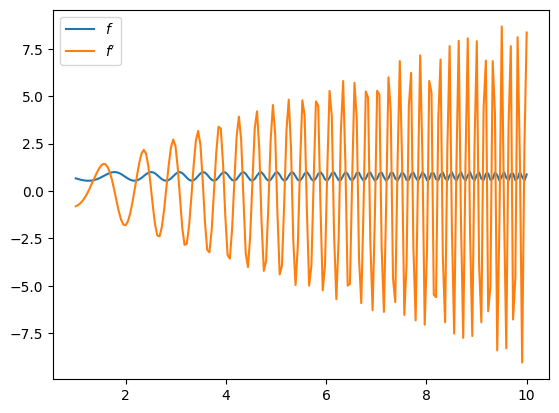

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(1, 10, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper left')
plt.show()

JAX's `grad` function can also compute gradients of functions with multiple arguments. Let's see an example of computing the gradient of a function with respect to multiple variables:

In [38]:
# Define a function of two variables
def g(x, y):
    return jnp.sin(x) * jnp.cos(y)

# Compute the gradient of g with respect to both x and y
g_prime = jax.grad(g, argnums=(0, 1))

# Evaluate the gradient at (x, y) = (0, 0)
result = g_prime(0.0, 0.0)
print("Gradient of g at (0, 0):", result)

Gradient of g at (0, 0): (Array(1., dtype=float32, weak_type=True), Array(-0., dtype=float32, weak_type=True))


In this example, `argnums=(0, 1)` specifies that we want to compute the gradient with respect to both the first and second arguments of the function `g`.

#### Using `jax.value_and_grad` for Function and Gradient Computation

JAX provides the `value_and_grad` function to compute both the function value and its gradient simultaneously, improving efficiency. Here's an example:

In [43]:
# Compute the function value and gradient simultaneously
value, grad_value = jax.value_and_grad(f)(jnp.array(3.0))

print("Function value:", value)
print("Gradient of f at x=3.0:", grad_value)

Function value: 0.9162743
Gradient of f at x=3.0: 2.1897266


### Computing Hessian

The `hessian` function computes the Hessian matrix of the function `f`, which represents the matrix of second-order partial derivatives.

In [45]:
# Compute the Hessian matrix of f
hessian_f = jax.hessian(f)

# Evaluate the Hessian at x = 2
result = hessian_f(2.0)
print("Hessian of f at x=2:", result)

Hessian of f at x=2: 2.4463372


The `hessian` function computes the Hessian matrix of the function `f`, which represents the matrix of second-order partial derivatives.

### Computing Jacobians

JAX provides a `jacobian` function to compute the Jacobian matrix of a vector-valued function.

Let's see an example

In [47]:
# Define a vector-valued function
def h(x):
    return jnp.array([x[0] ** 2, jnp.sin(x[1])])

# Compute the Jacobian of h using forward-mode differentiation
jacobian_h = jax.jacfwd(h)

# Evaluate the Jacobian at x = [1, 0]
result = jacobian_h(jnp.array([1.0, 0.0]))
print("Jacobian of h at [1, 0]:", result)

Jacobian of h at [1, 0]: [[2. 0.]
 [0. 1.]]
